In [1]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import os
from os.path import join
import numpy as np
import sklearn.neighbors as skn
from sklearn.linear_model import LinearRegression
import tqdm
from scipy.stats import norm
import json
import pandas as pd
from collections import defaultdict

# torch
import torch
import torch_geometric as pyg

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
mpl.style.use('style.mcstyle')
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

# ili
import ili
from ili.dataloaders import NumpyLoader, StaticNumpyLoader
from ili.inference.runner_sbi import SBIRunner
from ili.validation.metrics import PlotSinglePosterior, PosteriorCoverage
from ili.utils import IndependentTruncatedNormal, Uniform, IndependentNormal

from tools.plot_tools import binned_plot

Using device: cpu


In [2]:
mdir = './saved_models'

def r2logm(r):
    # see preprocessing.ipynb for this measurement
    coef = 0.36752
    intercept = -5.30640
    return (np.log10(r)-intercept)/coef

In [141]:
datanames = ['wC50', 'wC100', 'dC50', 'dC100']
runnames = ['base', 'gals_nle', 'summ_nle', 'gnn_npe']
modelnames = ['msig', 'pamico', 'gals_nle', 'summ_nle', 'gnn_npe']
Nfolds=10

datatitles = dict(
    wC50='Wide $50\%$',
    wC100='Wide $100\%$',
    dC50='Deep $50\%$',
    dC100='Deep $100\%$'
)
modeltitles = dict(
    msig='$M-\sigma$',
    pamico='$M-\lambda_{\\rm AMICO}$',
    gals_nle='GALS-NLE',
    summ_nle='SUMM-NLE',
    gnn_npe='GNN-NPE'
)

## Check suite

In [4]:
folds = range(10)
to_count = ['posterior.pkl', 'msig.npz', 'posterior_samples.npy']

saved_models = os.listdir(mdir)
for d in datanames:
    for m in runnames:
        counter = defaultdict(int)
        for f in folds:
            dirname = f'apr24_{m}_{d}_f{f}'
            filelist = os.listdir(join(mdir, dirname))
            for fn in filelist:
                if fn in to_count:
                    counter[fn] += 1
        print(f'{d} {m}:')
        for fn, c in counter.items():
            print(f'\t{fn}: {c}')
    print()

wC50 base:
	msig.npz: 10
wC50 gals_nle:
	posterior.pkl: 10
	posterior_samples.npy: 10
wC50 summ_nle:
	posterior.pkl: 10
	posterior_samples.npy: 10
wC50 gnn_npe:
	posterior.pkl: 10
	posterior_samples.npy: 9

wC100 base:
	msig.npz: 10
wC100 gals_nle:
	posterior.pkl: 10
	posterior_samples.npy: 10
wC100 summ_nle:
	posterior.pkl: 10
	posterior_samples.npy: 10
wC100 gnn_npe:
	posterior.pkl: 10
	posterior_samples.npy: 10

dC50 base:
	msig.npz: 10
dC50 gals_nle:
	posterior.pkl: 8
	posterior_samples.npy: 8
dC50 summ_nle:
	posterior.pkl: 10
	posterior_samples.npy: 10
dC50 gnn_npe:
	posterior.pkl: 10
	posterior_samples.npy: 10

dC100 base:
	msig.npz: 10
dC100 gals_nle:
	posterior.pkl: 10
	posterior_samples.npy: 9
dC100 summ_nle:
	posterior.pkl: 10
	posterior_samples.npy: 10
dC100 gnn_npe:
	posterior.pkl: 10
	posterior_samples.npy: 9



## Load Everything

In [105]:
# load train/test
header = 'APR24'
datadir = './data/processed'

theta, fold, ids, richs = {}, {}, {}, {}
for d in datanames:
    dirpath = join(datadir, f'{header}{d}')
    print('Loading:', dirpath)
    theta[d] = np.load(join(dirpath, 'theta_batch.npy'))
    fold[d] = np.load(join(dirpath, 'folds_batch.npy'))
    ids[d] = np.load(join(dirpath, 'ids_batch.npy'))
    _s = np.load(join(dirpath, 'x_sum.npy'))
    richs[d] = _s[:,3]

Ndata = {d: len(theta[d]) for d in datanames}


Loading: ./data/processed/APR24wC50
Loading: ./data/processed/APR24wC100
Loading: ./data/processed/APR24dC50
Loading: ./data/processed/APR24dC100


In [107]:
Nsamp = 100
preds = defaultdict(dict)
for d in datanames:
    for r in runnames:
        # setup
        if r == 'base':
            preds[d]['msig'] = np.ones((Ndata[d], 2))*np.nan
            preds[d]['pamico'] = np.ones((Ndata[d], 2))*np.nan
        else:
            preds[d][r] = np.empty((Ndata[d], Nsamp, 1))

        # load
        for f in folds:
            dirname = f'apr24_{r}_{d}_f{f}'
            if r == 'base':
                # Msig
                samplefile = join(mdir, dirname, 'msig.npz')
                if not os.path.exists(samplefile):
                    print(f'Skipping {dirname}')
                    continue
                s = np.load(samplefile)
                place_ids = np.searchsorted(ids[d], s['ids'])
                np.put(preds[d]['msig'][:,0], place_ids, s['pred'])
                np.put(preds[d]['msig'][:,1], place_ids, s['std'])


                # Pamico
                samplefile = join(mdir, dirname, 'Pamico.npz')
                if not os.path.exists(samplefile):
                    print(f'Skipping {dirname}')
                    continue
                s = np.load(samplefile)
                place_ids = np.searchsorted(ids[d], s['ids'])
                np.put(preds[d]['pamico'][:,0], place_ids, s['pred'])
                np.put(preds[d]['pamico'][:,1], place_ids, s['std'])


            else:
                # ML models
                samplefile = join(mdir, dirname, 'posterior_samples.npy')
                if not os.path.exists(samplefile):
                    print(f'Skipping {dirname}')
                    continue
                s = np.load(samplefile)
                s = np.swapaxes(s, 0, 1)
                s = s[:, :Nsamp]  # subsample if necessary
                preds[d][r][fold[d] == f] = s

Skipping apr24_gnn_npe_wC50_f6
Skipping apr24_gals_nle_dC50_f3
Skipping apr24_gals_nle_dC50_f4
Skipping apr24_gals_nle_dC100_f1
Skipping apr24_gnn_npe_dC100_f7


In [108]:
# calculate percentiles from predictions
q = 100*np.array([0.16, 0.84, 0.5])
percs = defaultdict(dict)
for d in datanames:
    for m in modelnames:
        if m == 'msig' or m == 'pamico':
            t_ = preds[d][m]
            percs[d][m] = np.stack([t_[:,0]-t_[:,1], t_[:,0]+t_[:,1], t_[:,0]], axis=1).T
        else:
            t_ = preds[d][m]
            percs[d][m] = np.percentile(t_, q, axis=1)[...,0]

`preds` is organized by the following...

for base models:
`preds[dataname][modelname] = (Ntest, 2)` (mean, std)

for neural models:
`preds[dataname][modelname] = (Ntest, Nsamp, 1)`

## Check loss

In [109]:
def plot_loss(loss, ax, errs=[0.6, 1], color=None, **kwargs):
    # prepare losses
    L = max([len(x) for x in loss])
    lossnan = np.ones((len(loss), L))*np.nan
    for i, l in enumerate(loss):
        lossnan[i, :len(l)] = l
    
    q = []
    for e in errs:
        q += [0.5-e/2, 0.5+e/2]
    q += [0.5]
    q = np.array(q)*100
    
    x_ = range(L)
    percs = np.nanpercentile(lossnan, q=q, axis=0)
    for i in range(len(errs)):
        ax.fill_between(x_, percs[2*i], percs[2*i+1], alpha=0.2, color=color)
    ax.plot(x_, percs[-1], color=color, **kwargs)

wC50
wC100
dC50
dC100


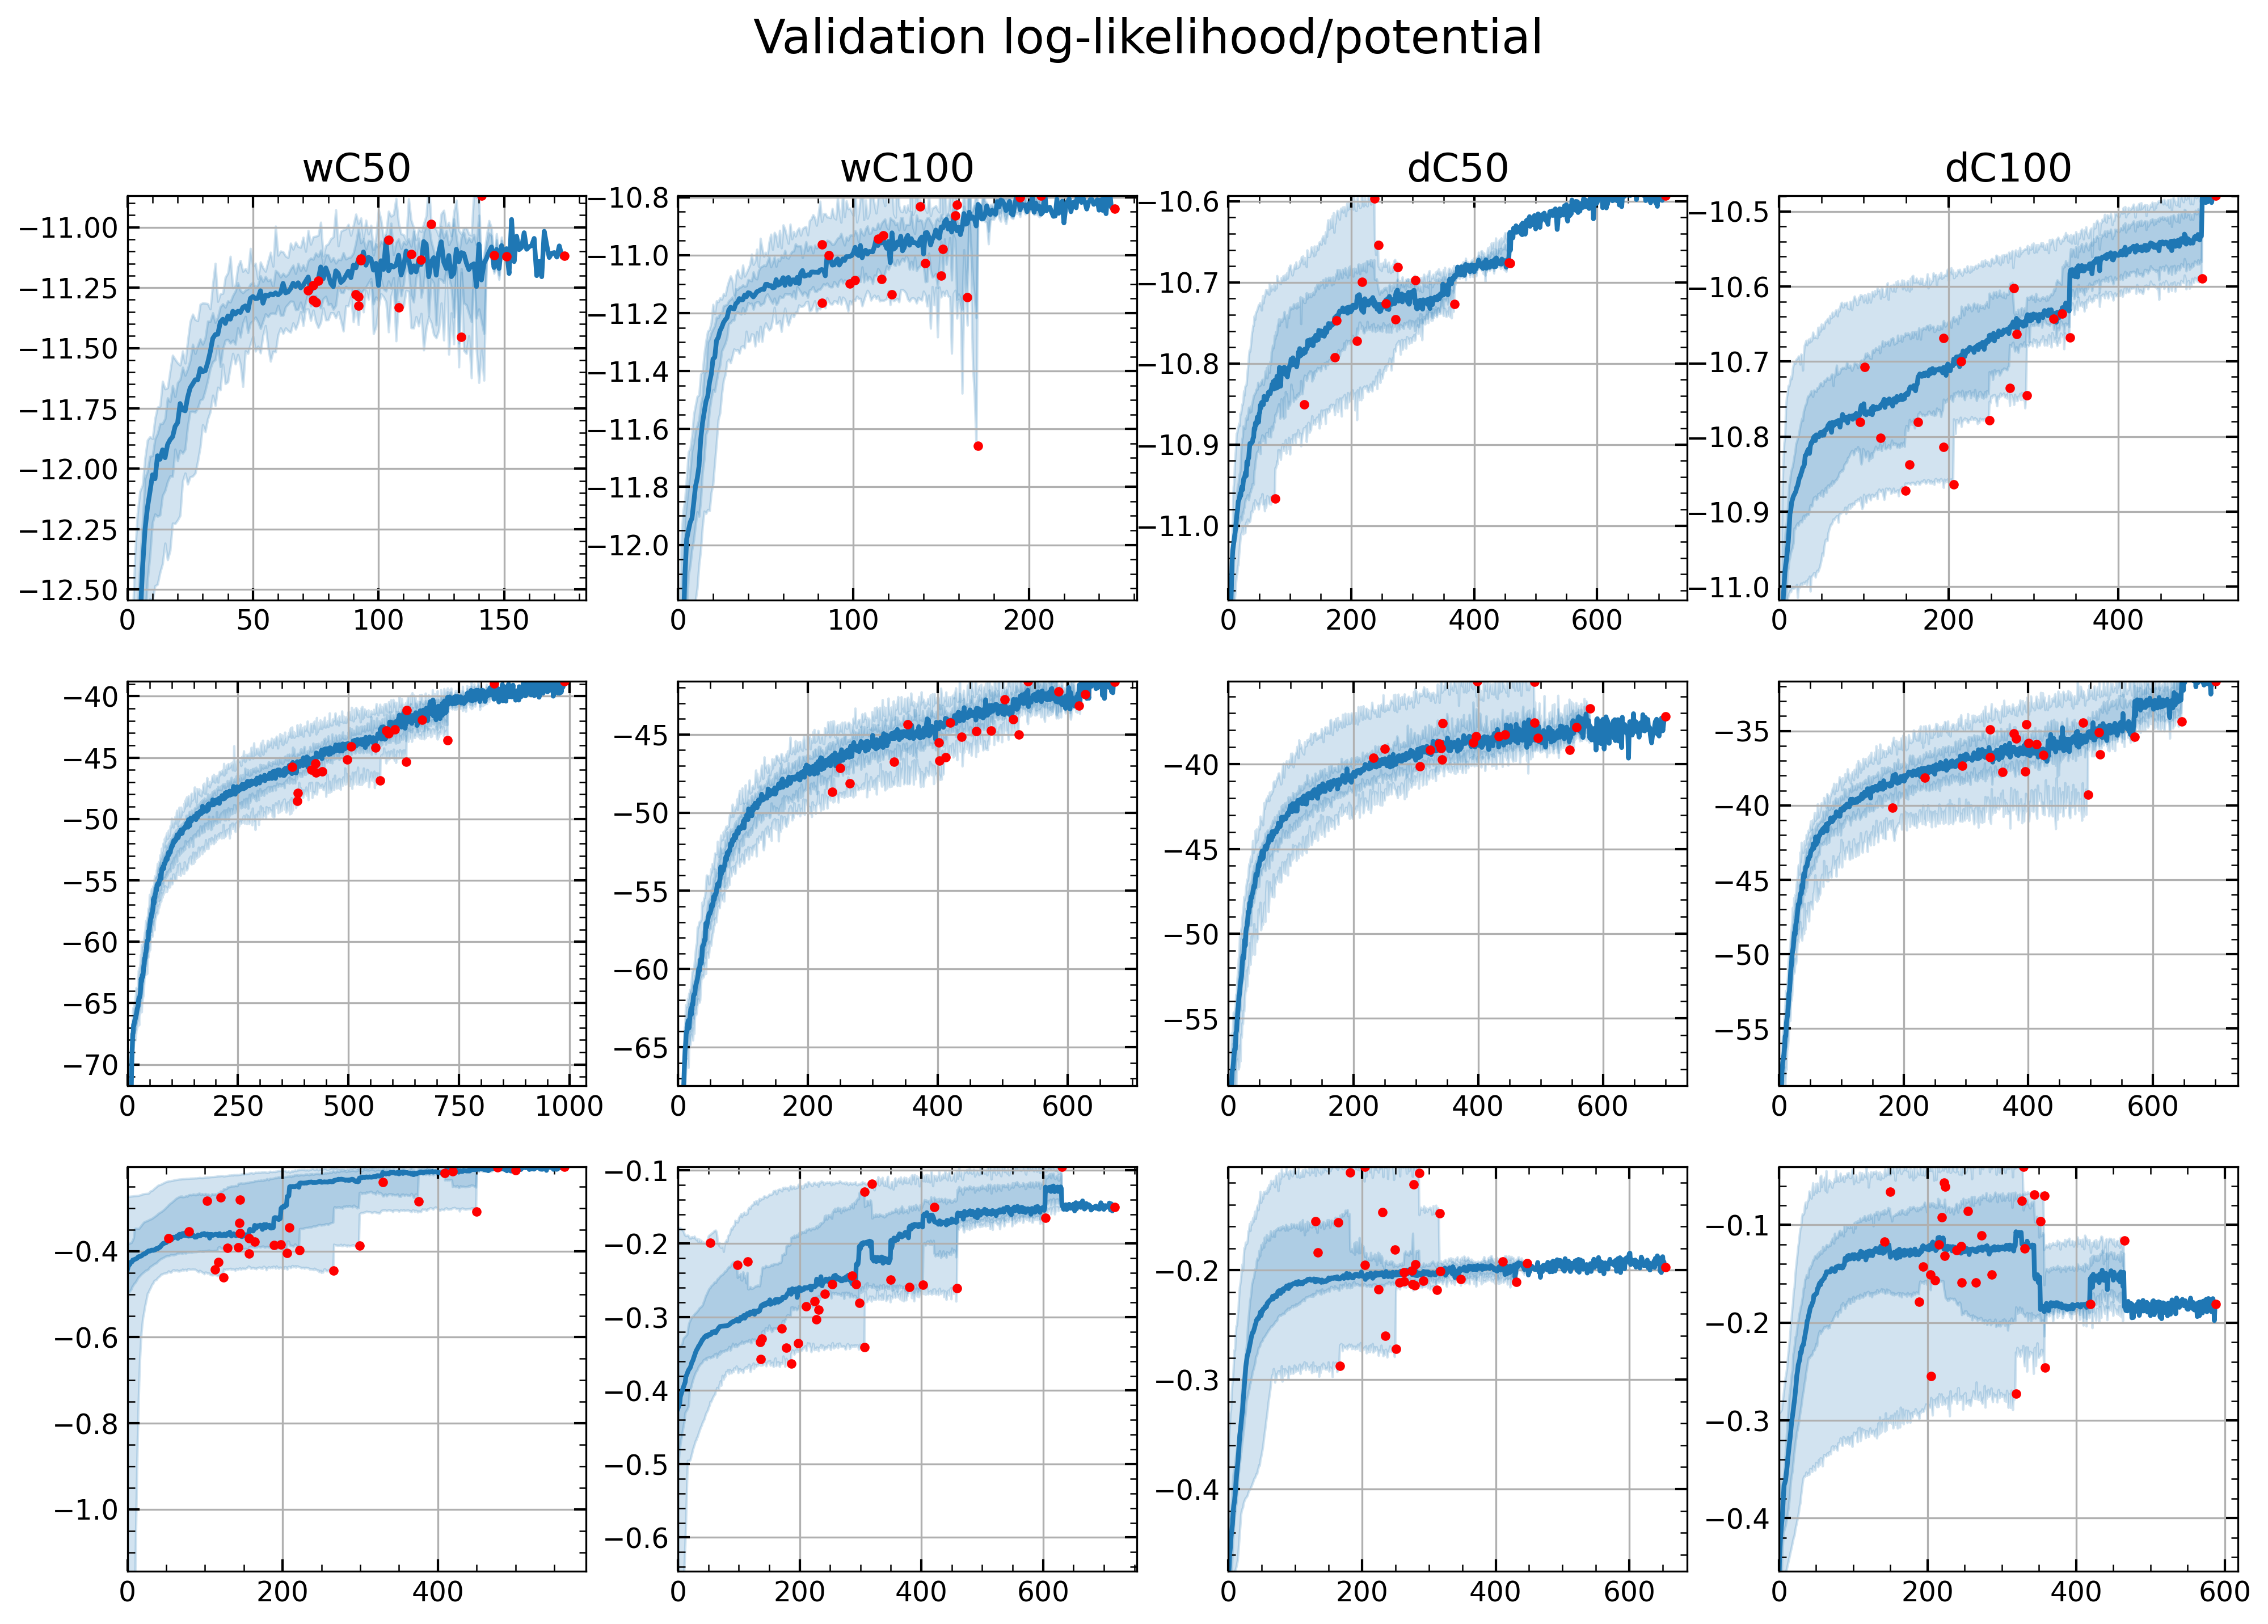

In [110]:
W, H = len(datanames), len(runnames)-1
fig, axs = plt.subplots(H, W, figsize=(W*4, H*3.5), sharex=False, sharey=False)
for i, d in enumerate(datanames):
    print(d)
    for j, r in enumerate(runnames[1:]):
        # load summaries
        summs = []
        for f in folds:
            dirname = f'apr24_{r}_{d}_f{f}'
            fn = join(mdir, dirname, 'summary.json')
            if not os.path.exists(fn):
                continue
            with open(fn, 'r') as f:
                summs.append(json.load(f))
        
        # append losses
        loss, valloss = [], []
        for s in summs:
            for m in s:
                loss.append(m['training_log_probs'])
                valloss.append(m['validation_log_probs'])

        
        ax = axs[j, i]
        # ax.semilogx()
        plot_loss(valloss, ax, color='C0', label='Training')
        for l in valloss:
            ax.plot(len(l), l[-1], '.', color='r')
        ymin = np.min([x[10] for x in valloss])
        ymax = np.max([x[-1] for x in valloss])
        ax.set_ylim(ymin, ymax)
        ax.set_xlim(0)

        if j == 0:
            ax.set_title(d)
        if j == W-1:
            ax.set_xlabel('Epoch')

fig.suptitle('Validation log-likelihood/potential', fontsize=20);

## Plot Examples

## Overlapping Posteriors

## Plot True vs. Predicted

In [164]:
xlim = min(x.min() for x in theta.values()), max(x.max() for x in theta.values())
xlim = np.array(xlim)
ylim = xlim.mean() + np.array([-1.2, 1.4])*xlim.ptp()/2

rlim = 1, 100  # richness limits
rlim = np.log10(rlim)

from scipy.stats import gaussian_kde
def sample_even(x, N, bins=40):
    # sample from x to form a uniform distribution
    ind = np.digitize(x, np.linspace(*xlim, 30+1))
    to_choose = []
    for i in range(1, bins+1):
        binx = np.argwhere(ind == i).flatten()
        to_choose.append(
            np.random.choice(binx, min(len(binx), N//bins), replace=False)
        )
    to_choose = np.concatenate(to_choose)
    mask = np.zeros(len(x), dtype=bool)
    mask[to_choose] = True
    return mask

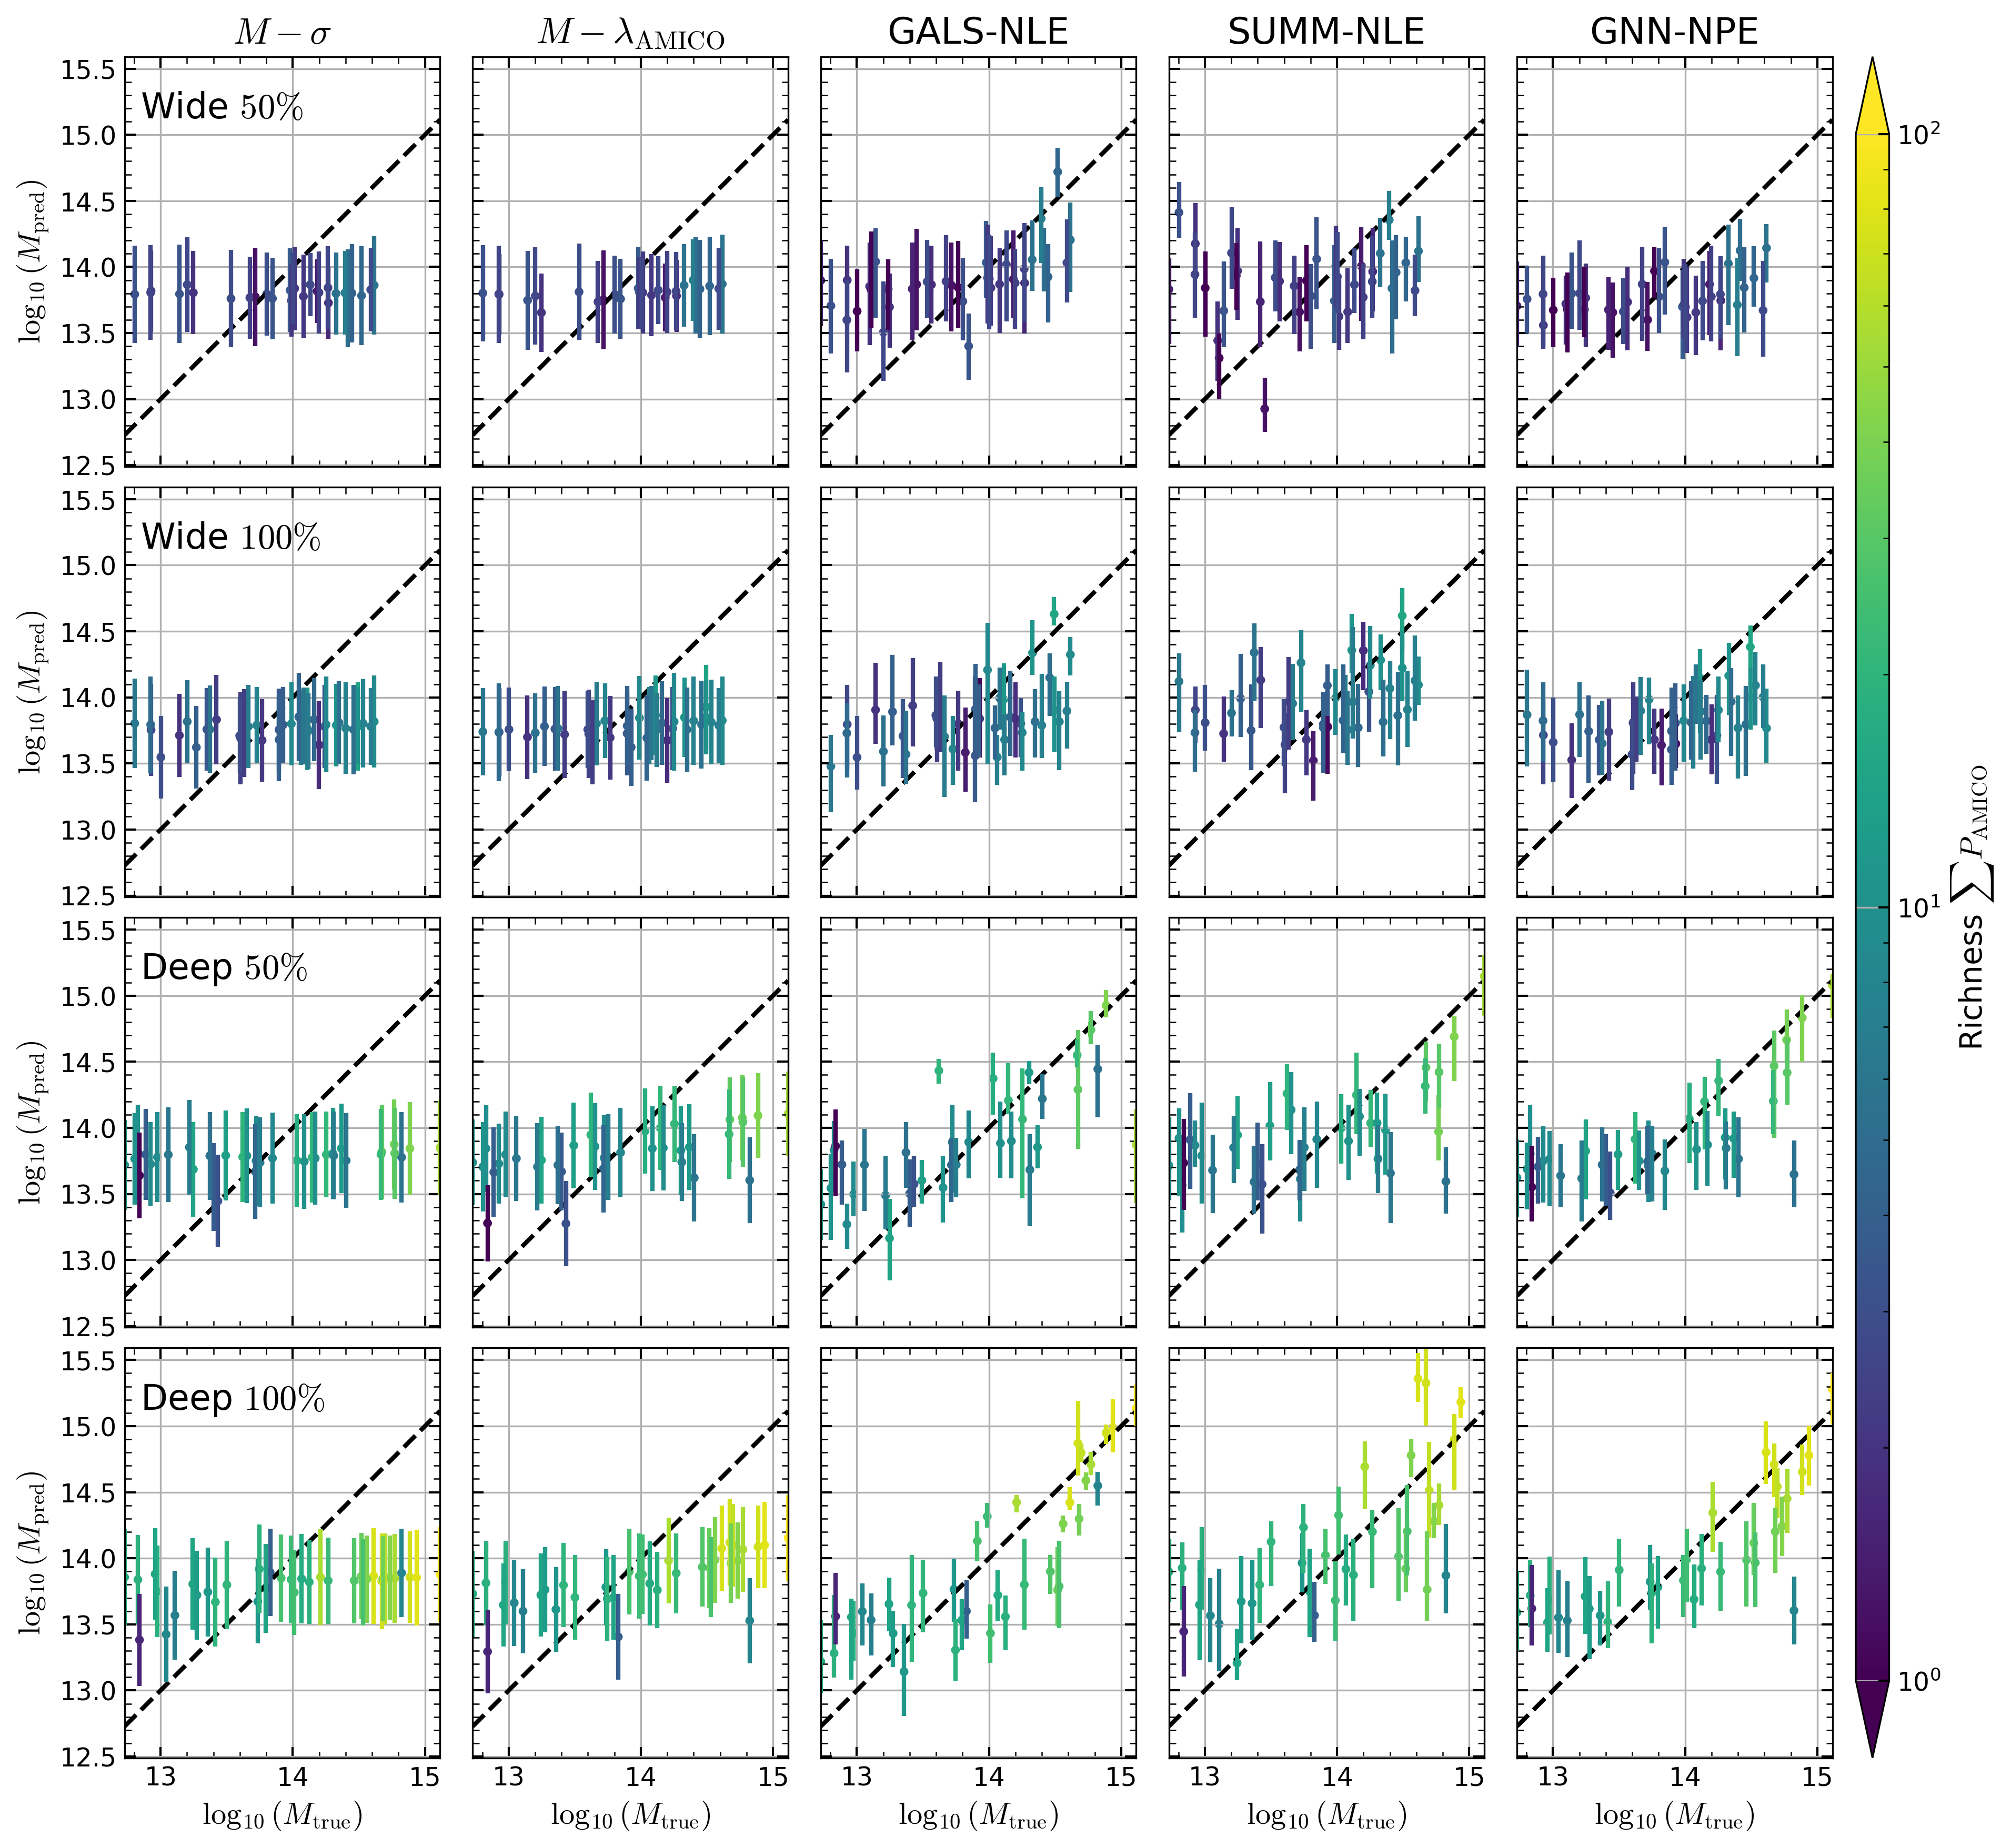

In [166]:
H, W = len(datanames), len(modelnames)
to_plot = 120

fig = plt.figure(figsize=(W*2.9, H*3.5))
gs = fig.add_gridspec(H, W+1, width_ratios=[1]*W+[0.1], wspace=0.05, hspace=0.05)

cmap = plt.cm.get_cmap('viridis')
for i, d in enumerate(datanames):
    mask = sample_even(theta[d], to_plot)
    _r = np.log10(richs[d])
    _c = cmap((_r-rlim[0])/rlim.ptp())

    for j, m in enumerate(modelnames):
        ax = fig.add_subplot(gs[i, j], aspect='equal')
        ax.plot(xlim, xlim, 'k--')
        ax.errorbar(
            theta[d][mask], percs[d][m][2,mask], 
            yerr=[percs[d][m][2,mask]-percs[d][m][0,mask], percs[d][m][1,mask]-percs[d][m][2,mask]], 
            fmt='none', ecolor=_c[mask]
        )
        ax.scatter(theta[d][mask], percs[d][m][2,mask], marker='.', c=_c[mask])

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        if i==0:
            ax.set_title(modeltitles[m])
        if j==0:
            ax.set_ylabel('$\log_{10}(M_{\\rm pred})$')
            ax.text(0.05, 0.85, datatitles[d], 
                    fontsize=16, transform=ax.transAxes)
        else:
            ax.set_yticklabels([])
        if i==H-1:
            ax.set_xlabel('$\log_{10}(M_{\\rm true})$')
        else:
            ax.set_xticklabels([])
ax = fig.add_subplot(gs[:, -1])
norm = mcolors.LogNorm(vmin=10**rlim[0], vmax=10**rlim[1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=ax, label='Richness $\sum P_{\\rm AMICO}$', extend='both')
fig.savefig('figures/true_vs_pred.pdf', bbox_inches='tight');

## Scatter vs Richness, Redshift

## Coverage plots